In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.signal as signal
from scipy.interpolate import interp1d
import pandas as pd
import math
import mat73
import csv
import sys
sys.path.insert(0, os.path.abspath('../lib'))
import sig_proc as sp
import BP_func 

plt.style.use('ggplot')


class blood_pressure(BP_func.feature_extraction):
    def __init__(self, sr, abp):
        self.sr=sr
        self.filt_ppg = abp

def get_bp(value):
    if not isinstance(value, blood_pressure):
        raise ValueError("value muse be BP instance")
    pk_locs, tr_locs = value.find_peak_trough()
    sbp = np.mean(value.filt_ppg[pk_locs])
    dbp = np.mean(value.filt_ppg[tr_locs])
    return sbp, dbp



# Load data

In [3]:
sr = 125
# Load data
folder = '../../../MIMIC II/'
data_name = 'Part_1'
data_path = folder  + data_name + '.mat'
data_dict = mat73.loadmat(data_path)

In [7]:


rows = np.zeros((3000, 18))

for i in range(1613, 1614):
    
    ppg = data_dict[data_name][i][0][0:1000]
    abp = data_dict[data_name][i][1][0:1000]
    # ecg = data_dict['Part_1'][i][2][0:1000]
    
    pf = feature_extraction(sr, ppg)
    sbp, dbp = get_bp(blood_pressure(sr, abp))

    
    feat_tab = pf.get_feature()
    
    rows[i][0] = int(i)
    rows[i][1] = sbp
    rows[i][2] = dbp
    
    cnt=3
    for f in feat_tab:
        rows[i][cnt] = f
        cnt+=1
        


# # writing to csv file 
# with open('part1_feature.csv', 'w', newline="") as csvfile: 
#     # creating a csv writer object 
#     csvwriter = csv.writer(csvfile) 
#     # writing the data rows 
#     csvwriter.writerows(rows)




C:\Users\10712064\AppData\Local\Continuum\anaconda3\envs\Thor\lib\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\10712064\AppData\Local\Continuum\anaconda3\envs\Thor\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


[107.31107660455487,
 113.26775692307547,
 0.1416,
 0.4176,
 0.7334310850439885,
 0.28753665689149555,
 2.553527331218524,
 0.096,
 0.272,
 1.8333333333333333,
 0.20800000000000002,
 1.8888888888888888,
 0.176,
 1.75,
 1.75]

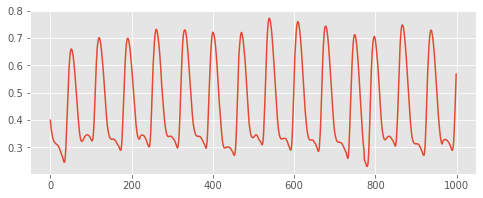

In [17]:

# pf = feature_extraction(sr, data_dict[data_name][498][0][0:1000])
plt.figure(figsize=(8,3))
plt.plot(pf.filt_ppg)
# plt.plot(pf.trs_loc, pf.filt_ppg[pf.trs_loc], '*', c='b')
# plt.plot(pf.pks_loc, pf.filt_ppg[pf.pks_loc], '*', c='b')
# for i in range(pf.num_pulse):
#     if pf.hq_idx[i]==1:
#         plt.figure(figsize=(3,3))
#         plt.plot(pf.filt_ppg[pf.pulse_loc_set[i][0]: pf.pulse_loc_set[i][2]])
#         print(min(pf.filt_ppg[pf.pulse_loc_set[i][0]: pf.pulse_loc_set[i][2]]))


# plt.plot(max(pf.filt_ppg) - pf.filt_ppg )
# for n in range(pf.num_pulse):
    
#     tr_loc0 = pf.pulse_loc_set[n][0]
#     tr_loc1 = pf.pulse_loc_set[n][2]
#     plt.figure(figsize=(3,3))
#     # plt.title('xcorr:', pf.cr[n])
#     plt.plot(pf.filt_ppg[tr_loc0: tr_loc1+1])
# print(pf.hq_idx)






# BP prediction


In [33]:
import pandas as pd 
from sklearn import datasets
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression  
import numpy as np  
from sklearn.metrics import mean_squared_error, r2_score
import csv
# dataset = pd.read_csv('../../data/cleaned_further.csv',names = ['alpha','PIR', 'ptt', 'bpmax' ,'bpmin', 'hrfinal', 'ih', 'il', 'meu', 'j', 'k','l','m','n','o','p','q','r','s'])
dataset = pd.read_csv('feature_clean.csv',names = ['serial','sbp', 'dbp', 'HR' ,'alpha', 'St', 'Dt', 'Ih', 'Il', 'PIR'])

# X = dataset[['alpha','PIR', 'ptt','hrfinal', 'ih', 'il', 'meu','j', 'k','l','m','n','o','p','q','r','s']]
X = dataset[['HR','St', 'Dt', 'PIR']]
y = dataset[['sbp','dbp']]

sbp = list()
dbp = list()
real_BP = list()
with open('feature_clean.csv', 'r') as csvfile:
	csv_reader = csv.reader(csvfile, delimiter = ',')
	# print csv_reader
	for row in csv_reader:
		#ptt.append(float(row[2]))
		sbp.append(float(row[1]))
		dbp.append(float(row[2]))

	real_BP = list()
	for i in range(len(sbp)):
		BP_actual = (2*dbp[i] + sbp[i])/3
		real_BP.append(BP_actual)


X_train, X_test, y_train, y_test = train_test_split(X, sbp, test_size=0.2, random_state=0) 

from sklearn.preprocessing import StandardScaler
sc_X=StandardScaler()
x_train=sc_X.fit_transform(X_train)
x_test=sc_X.transform(X_test)



from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state = 2)

#regressor = LinearRegression() 
#print dataset.isnull().any()
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)


#print('Coefficients: \n', regressor.coef_)
# The mean squared error
from sklearn import metrics  
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))



# # Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred))

Mean Absolute Error: 17.271362414528433
Mean Squared Error: 485.6084403714382
Root Mean Squared Error: 22.0365251428495
Variance score: 0.06


In [21]:
import file_read
folder = 'BP1220-0103'
subjects = ['Coco', 'Gary', 'Jack', 'Molly', 'Shawn', 'Tanya', 'Vanessa']

# sampling
sr =50
window = sr*30
    
# Vital sign dictionary initialize
BP_pred = {
    'subject': [],
    'HR': [],
    'SBP':[],
    'DBP':[]
}


# sampling rate
sr = 50
SNR_HR_thresh = 0.8

# Filter parameters
b, a = sp.bp_filter(0.5, 10, sr, 4)

rows = []
for subject in subjects:
    # file_path = os.path.join(folder, subject)
    file_path = os.path.join(folder, subject, 'day1', 'AM')
    # specific data path
    full_file_path = os.path.join("../../data", file_path)
    
    s1 = 0*sr
    s2 = s1+window    
    
    G2= file_read.load_ppg(full_file_path, 'G2')
    G2_sample = np.array(G2[s1:s2])

    filt_G2 = signal.filtfilt(b,a, sp.flip_up_down(G2_sample))
    # filt_G2 = sp.z_score(filt_G2)
    filt_G2 = np.array(list(map(sp.value_trans, filt_G2)))
    filt_G2 = filt_G2 + abs(min(filt_G2))

    pf = BP_func.feature_extraction(sr, filt_G2)
    
    feat_tab = pf.get_feature()

    row = []
    if feat_tab[0] != None:
        for f in feat_tab:
            row.append(f)
        rows.append(row)
        

# open the file in the write mode
# writing to csv file 
with open(folder + '_feature.csv', 'w', newline="") as csvfile: 
    # creating a csv writer object 
    csvwriter = csv.writer(csvfile) 
    # writing the data rows 
    csvwriter.writerows(rows)

In [34]:
test_dataset = pd.read_csv(folder + '_feature.csv',names = ['HR' ,'alpha', 'St', 'Dt', 'Ih', 'Il', 'PIR'])

# X = dataset[['alpha','PIR', 'ptt','hrfinal', 'ih', 'il', 'meu','j', 'k','l','m','n','o','p','q','r','s']]
# X = dataset[['HR' ,'alpha','St', 'Dt','Ih', 'Il', 'PIR']]
test_X = test_dataset[['HR','St', 'Dt', 'PIR']]


regressor.predict(X)

array([145.06937697, 145.67049267, 145.83931362, ..., 146.71111734,
       145.71836923, 145.24339832])

In [35]:
test_X

,HR,St,Dt,PIR
0,69.362355,0.382500,0.498125,6.898247
1,81.377200,0.307027,0.438919,5.881692
2,76.327414,0.306667,0.486667,8.690376
3,77.113073,0.310556,0.476667,6.507656
4,71.165457,0.399355,0.453548,3.311221
5,72.347840,0.381818,0.453939,6.809253
6,75.457453,0.411034,0.394483,3.076641


In [37]:
X.head()

,HR,St,Dt,PIR
0,123.262446,0.124000,0.362857,2.593353
1,117.362271,0.119385,0.392000,2.626415
2,114.344569,0.125333,0.400000,2.526229
3,116.502688,0.126154,0.388923,2.767183
4,107.311452,0.133600,0.425600,2.547856


# Check PPG physiological feature

AttributeError: 'feature_extraction' object has no attribute 'st_point'

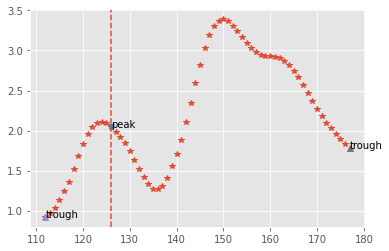

In [ ]:
pkLoc = pf.pulse_loc_set[0][1]
trLoc0 = pf.pulse_loc_set[0][0]
trLoc1 = pf.pulse_loc_set[0][2]


t_axis = np.arange(len(ppg))[trLoc0: trLoc1]


plt.plot(t_axis, ppg[trLoc0: trLoc1], '*')
plt.plot(pkLoc, ppg[pkLoc], 'v')
plt.text(pkLoc, ppg[pkLoc], 'peak')

plt.axvline(pkLoc, ls='--')

plt.plot(trLoc0, ppg[trLoc0], '^')
plt.plot(trLoc1, ppg[trLoc1], '^')
plt.text(trLoc0, ppg[trLoc0], 'trough')
plt.text(trLoc1, ppg[trLoc1], 'trough')

pf.phy_features()
st_point = pf.st_point
dt_point = pf.dt_point

color_map = ['blue','green', 'purple', 'cyan']
v = [0.1, 0.25, 0.33, 0.5]
for i in range(4):
    plt.text(st_point[i], ppg[st_point[i]], str(v[i]))
    plt.text(dt_point[i], ppg[dt_point[i]], str(v[i]))

    plt.plot(st_point[i], ppg[st_point[i]], 'o', color=color_map[i])
    plt.plot(dt_point[i], ppg[dt_point[i]], 'o', color=color_map[i])


# plt.plot(st_point[1]-1, ppg[st_point[1]-1], '*', c='red')


# Feature table
| #  | feature   |
|----|-----------|
| 0  | sbp       |
| 1  | dbp       |
| 2  | HR        |
| 3  | alpha     |
| 4  | St        |
| 5  | Dt        |
| 6  | Ih        |
| 7  | Il        |
| 8  | PIR       |
| 9  | Sw10      |
| 10 | St10+Dt10 |
| 11 | Dt10/St10 |
| 12 | St25+Dt25 |
| 13 | Dt25/St25 |
| 14 | St33+Dt33 |
| 15 | Dt33/St33 |
| 16 | Dt50/St50 |

